# Quantum Phase Estimation using the Sampler primitive

The quantum phase estimation (QPE) algorithm is an important subrountine in quantum computaton. It serves as a central building block of many quantum algorithms including the Shor's factoring algorithm and the quantum algorithm for linear systems of equations (HHL algorithm). In this tutorial, you will build a parameterized version of QPE circuit and run it using the Sampler primitive which makes running parameterized circuits very easy.

## Before you begin

This tutorial requires a Qiskit Runtime service instance. If you haven't done so already, please follow the [Getting Started Guide](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/getting_started.html) to set one up.

## Background information

### Quantum phase estimation algorithm

Suppose a unitary operator $U$ has an eigenvector $|\psi \rangle$ with eigenvalue $e^{2\pi i \theta}$, where the value of $\theta$ is unknown. The goal of the QPE algorithm is to estimate $\theta$. To perform the estimation we assume that we have available black boxes (sometimes known as *oracles*) capable of preparing the state $|\psi \rangle$ and performing the controlled-$U^{2^j}$ operation. 

The use of black boxes indicates that the QPE algorithm is not a complete algorithm, but rather a kind of subroutine. When combined with other subroutines, it can be used to perform interesting computational tasks, such as the Shor's factoring algorithm and the quantum algorithm for linear systems of equations (HHL algorithm).

(TODO: the above are almost exact quote from Mike&Ike, need to rephrase and cite)

We are not going to explain the details of the QPE algorithm here. If you want to learn more, you can read the chapter about the QPE algorithm in [the Qiskit textbook](https://learn.qiskit.org/course/ch-algorithms/quantum-phase-estimation).

## Plan

As explained above, there are black boxes in the QPE algorithm to prepare the state $|\psi \rangle$ and performing the controlled-$U^{2^j}$ operation. In this tutorial, you will prepare a series of QPE circuits containing different black boxes corresonding to different phases. You will then run these circuits using the Sampler primitive and analyze the results. As you will see, the Sampler primitive makes running parameterized circuits very easy. Instead of creating a series of QPE circuits, you only need to create *one* QPE circuit with a parameter specifying the phase the black boxs generate and a series of phase values for the parameter.

<div class="alert alert-info">

Note

In a typical usage of the QPE algorithm such as the Shor's factoring algorithm, the black boxes are not configured by the user but rather are specified by other subroutines. The purpose of this tutorial is to use the QPE algorithm to illustrate the ease of running parameterized circuits using the Sampler primitive.

</div>



## Step 1: Create QPE circuits

### Create a parameterized QPE circuit

The procedure of the QPE algorithm goes as follows:

1. Create a circuit with two quantum registers (the first for estimating the phase and the second for storing the eigenvector $|\psi\rangle$) and one classical register for readout.
2. Initialize the qubits in the first register as $|0\rangle$ and the second register as $|\psi\rangle$.
3. Create superposition in the first register.
4. Apply controlled-$U^{2^j}$ black box.
5. Apply inverse quantum Fourier transform (QFT) to the first register.
6. Measure the first register.

Using the code below, you creates a function `create_qpe_circuit` for creating a QPE circuit given the keyword argument `theta` and `num_qubits`. Note the `theta` doesn't contain the $2\pi$ factor. The `num_qubits` argument specifies the number of qubits in the first register. More qubits will provide more precisions for the phase estimation. 

In [1]:
import numpy as np

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.circuit.library import QFT

def create_qpe_circuit(theta, num_qubits):
    # Step 1: Create a circuit with two quantum registers and one classical register
    first = QuantumRegister(size=num_qubits, name='first')  # the first register for phase estimation
    second = QuantumRegister(size=1, name='second')  # the second register for storing eigenvector |psi>
    classical = ClassicalRegister(size=num_qubits, name='readout') # classical register for readout
    qpe_circuit = QuantumCircuit(first, second, classical)

    # Step 2: Initialize the qubits
    # All qubits are initialized in |0> by default, no extra code are needed to initialize the first register
    qpe_circuit.x(second)  # Initialize the second register with state |psi> which is |1> in this example

    # Step 3: Create superposition in the first register
    qpe_circuit.barrier()  # barriers are added to seperate each step of the algorithm for better visualization
    qpe_circuit.h(first)

    # Step 4: Apply controlled-U^(2^j) black box
    qpe_circuit.barrier()
    for j in range(num_qubits):
        qpe_circuit.cp(theta*2*np.pi*(2**j), j, num_qubits)  # theta doesn't contain the 2 pi factor

    # Step 5: Apply inverse QFT to the first register
    qpe_circuit.barrier()
    qpe_circuit.compose(QFT(num_qubits, inverse=True), inplace=True)

    # Step 6: Measure the first register
    qpe_circuit.barrier()
    qpe_circuit.measure(first, classical)

    return qpe_circuit

If you pass a real number to the `theta` argument in the `create_qpe_circuit` function, it will return a circuit with a fixed phase encoded.

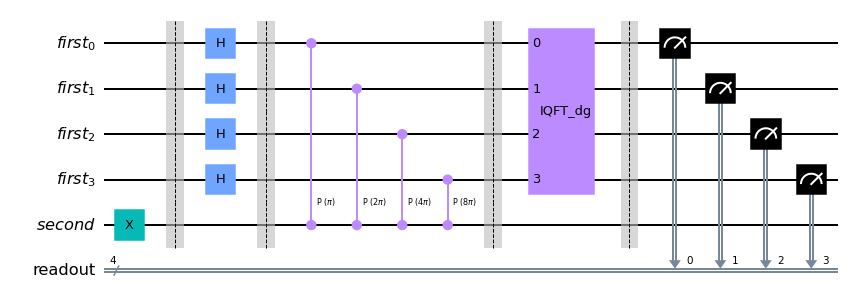

In [2]:
qpe_circuit_fixed_phase = create_qpe_circuit(1/2, 4) # create a QPE circuit fixed theta=1/2
qpe_circuit_fixed_phase.draw()

However, if you pass a [Parameter](https://qiskit.org/documentation/stubs/qiskit.circuit.Parameter.html) object instead, it will return a parameterized circuit whose parameter values can be assigned after the circuit has been created. You will use the parameterized verssion of the QPE circuit for the rest of the tutorial.

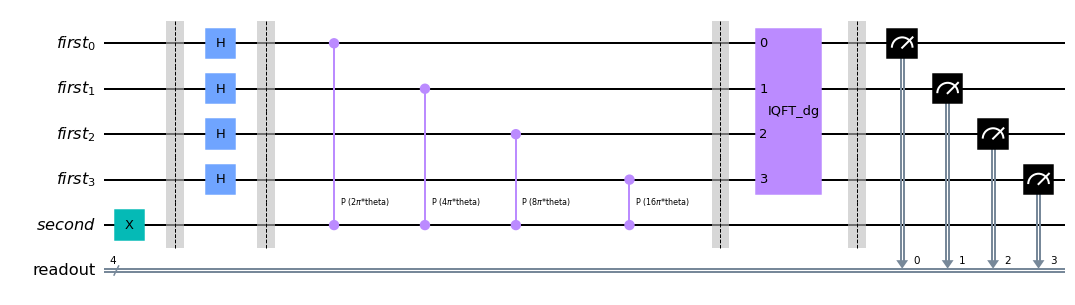

In [3]:
from qiskit.circuit import Parameter

theta = Parameter('theta')  # create a parameter `theta` whose values can be assigned later
qpe_circuit_parameterized = create_qpe_circuit(theta, 4)
qpe_circuit_parameterized.draw()

### Create a list of phase values to be assigned later

After creating the parameterized QPE circuit, you will create a list of phase values to be assigned to the circuit in the next step. You can use the code below to create a list of 21 phase values range from `0` to `2` with equal spacing, i.e. `0`, `0.1`, `0.2`, ..., `1.9`, `2.0`.

In [4]:
number_of_phases = 21
phases = np.linspace(0, 2, number_of_phases)
individual_phases = [[ph] for ph in phases]  # Phases need to be expressed as list of lists

## Step 2: Submit the circuits to a quantum computer on the cloud

### Connect to the Qiskit Runtime service 

First, you will connect to the Qiskit Runtime service instance that you created in [the first step](#Before-you-begin). We will use `ibmq_qasm_simulator` to run this tutorial.

In [5]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()
options = {'backend_name': 'ibmq_qasm_simulator'}  # use the simulator

### Run the parameterized circuits using the Sampler primitive

With the Qiskit Runtime service connected, a parameterized QPE circuit and a list of parameter values created, you are now ready to run the QPE circuits using the Sampler primitive. The `with ... as ...` syntax opens a Qiskit Runtime session configured with the `circuits`, `service` and `options` specified. Within the session, you will run the parameterized QPE circuit with 21 parameter values with just one line of code. The Sampler primitive will take the parameter values, assign them to the circuit and run it as 21 circuits with fixed parameter values and return a single job result.

(TODO: stress the benefits of parameterized circuits and advantange to Sampler primitive.)

The `Estimator` primitive has a similar API interface for parameterized circuits. See [the API reference](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/stubs/qiskit_ibm_runtime.Estimator.html) for more details.

In [6]:
from qiskit_ibm_runtime import Sampler

with Sampler(circuits=qpe_circuit_parameterized, service=service, options=options) as sampler:
    results = sampler(circuits=[0]*len(individual_phases), parameter_values=individual_phases)

## Step 3: Analyze the results


### Analyze the results from one circuit

After the job has been completed, you can start analyzing the results by looking at the histogram of one of the circuits. The (quasi-)probability distribution of the measurement outcome is stored in `results.quasi_dists` and you can access results from an individual circuit by passing the index of the circuit ($idx=6$ in the example below) you are interested in. 

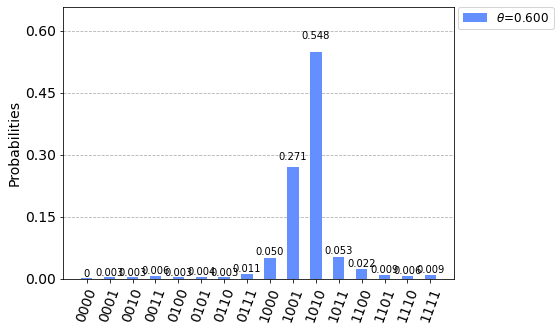

In [23]:
from qiskit.tools.visualization import plot_histogram

idx = 6
plot_histogram(results.quasi_dists[idx], legend=[f'$\\theta$={phases[idx]:.3f}'])

To estimate $\theta$, you need to divide the most likely outcome $N_1$ (`1010` in binary or `10` in decimal) by $2^n$, where $n$ is the number of qubits in the first register ($n=4$ in our example):

$$\theta = \frac{N_1}{2^n} =  \frac{10}{2^4} = 0.625. $$

This is close to the expected value of $0.6$, but you can do a better estimate by taking the weighted average of the most likely outcome (`1010` in binary or `10` in decimal) and the second most likely outcome (`1001` in binary or `9` in decimal):

$$\theta = \frac{P_1 \times \frac{N_1}{2^n} + P_2 \times \frac{N_2}{2^n}}{P_1 + P_2} = \frac{0.548 \times \frac{10}{2^4} + 0.271 \times \frac{9}{2^4}}{0.548 + 0.271} = 0.604,$$

where $N_1$ and $P_1$ are the most likely outcome and its probability and $N_2$ and $P_2$ are the second most likely outcome and its probability. The result $0.604$ is much closer to the expected value 0f $0.6$. We will use this method to analyze the results from all circuits.

### Analyze the results from all circuits

The helper functions below are used to find the $N_1$, $P_1$, $N_2$ and $P_2$ 

In [8]:
def most_likely_bitstring(result_dict):
    return max(result_dict, key=result_dict.get)

def find_neighbours(most_likely_key):

    if most_likely_key == len(most_likely_key)*'0':
        neighbor_left = len(most_likely_key)*'1'
    else:
        neighbor_left = format((int(most_likely_key,2)-1), '0%sb'%len(most_likely_key))

    if most_likely_key == len(most_likely_key)*'1':
        neighbor_right = len(most_likely_key)*'0'
    else:
        neighbor_right = format((int(most_likely_key,2)+1), '0%sb'%len(most_likely_key))

    return (neighbor_left, neighbor_right)

def estimate_phase(result_dict):
    num_1_key = most_likely_bitstring(result_dict)
    neighbor_left, neighbor_right = find_neighbours(num_1_key)

    num_1_prob = result_dict.get(num_1_key)
    neighbor_left_prob = result_dict.get(neighbor_left)
    neighbor_right_prob = result_dict.get(neighbor_right)

    if neighbor_left_prob is None:
        # neighbor_left doesn't exist
        if neighbor_right_prob is None:
            # both neighbors don't exist, num_2 is num_1
            num_2_key = num_1_key
            num_2_prob = num_1_prob
        else:
            # only neighbor_left doesn't exist, num_2 is neighbor_right
            num_2_key = neighbor_right
            num_2_prob = neighbor_right_prob
    elif neighbor_right_prob is None:
        # only neighbor_right doesn't exist, num_2 is neighbor_left
        num_2_key = neighbor_left
        num_2_prob = neighbor_left_prob
    elif neighbor_left_prob > neighbor_right_prob:
        # both neighbours exist, num_2 is neighor_left because it has higher probability
        num_2_key = neighbor_left
        num_2_prob = neighbor_left_prob        
    else:
        # both neighbours exist, num_2 is neighor_right because it has higher probability
        num_2_key = neighbor_right
        num_2_prob = neighbor_right_prob

    num_1_phase = (int(num_1_key, 2) / 2**4)
    num_2_phase = (int(num_2_key, 2) / 2**4)

    phase_estimated = (num_1_phase * num_1_prob + num_2_phase * num_2_prob) / (num_1_prob + num_2_prob)

    return phase_estimated

In [9]:
qpe_solution = []
for idx, result in enumerate(results.quasi_dists):
    qpe_solution.append(estimate_phase(result))

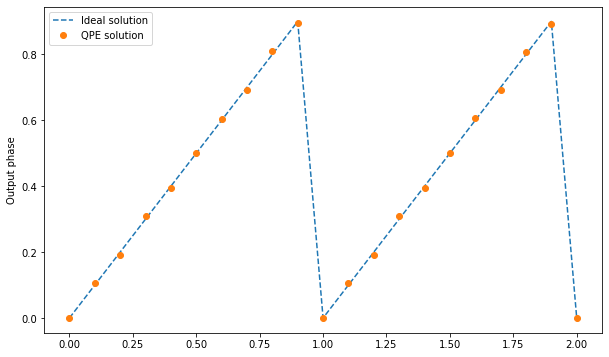

In [10]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 6))
ideal_solution = np.append(
    phases[:(number_of_phases-1)//2], 
    np.subtract(phases[(number_of_phases-1)//2:-1], 1)
)
ideal_solution = np.append(ideal_solution, np.subtract(phases[-1], 2))
plt.plot(phases, ideal_solution, '--', label='Ideal solution')
plt.plot(phases, qpe_solution, 'o', label='QPE solution')

plt.ylabel('Output phase')
plt.legend()

TODO:
- Add summary
- Add qiskit-ibm-runtime version
- Add qiskit version table
- Add qiskit copyright